Ridge Regression

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  


tr_path = './train.csv'

data = pd.read_csv(tr_path)  


data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
data.loc[:, data.isnull().any()]

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,NaN,None,0.0,Gd,TA,No,Unf,Unf,SBrkr,TA,Attchd,1999.0,RFn,TA,TA,NaN,NaN,NaN
1456,85.0,NaN,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,TA,Attchd,1978.0,Unf,TA,TA,NaN,MnPrv,NaN
1457,66.0,NaN,None,0.0,TA,Gd,No,GLQ,Unf,SBrkr,Gd,Attchd,1941.0,RFn,TA,TA,NaN,GdPrv,Shed
1458,68.0,NaN,None,0.0,TA,TA,Mn,GLQ,Rec,FuseA,NaN,Attchd,1950.0,Unf,TA,TA,NaN,NaN,NaN


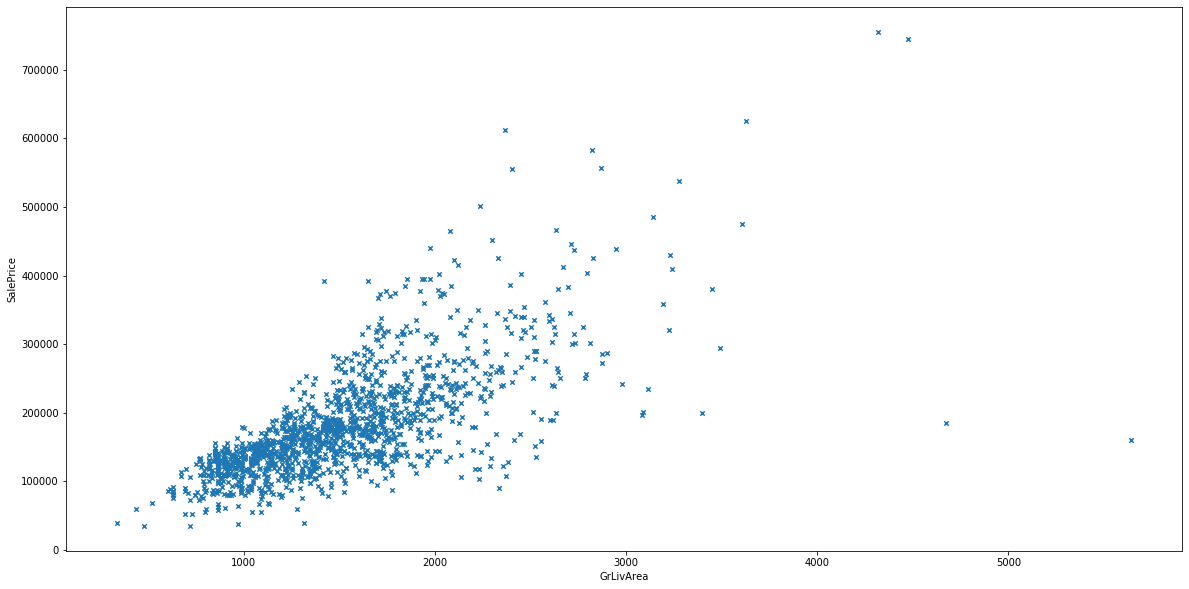

In [3]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');

$$y_{cent} = y_0 - \bar{y}$$


$$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$

In [5]:
def preprocess_for_regularization(data, y_column_name, x_column_names):
    X=data[x_column_names]
    y=data[y_column_name]
    y_mean=np.mean(y)
    y_cent=y-y_mean
    s_X=np.std(X)
    X_mean=np.mean(X)
    
    X_std=(X-X_mean)/s_X
    
    return pd.concat([X_std, y_cent], axis=1)

In [6]:
data = pd.read_csv(tr_path).head()
prepro_data = preprocess_for_regularization(data,'SalePrice', ['GrLivArea','YearBuilt'])
print(prepro_data)

   GrLivArea  YearBuilt  SalePrice
0  -0.082772   0.716753     7800.0
1  -1.590161  -0.089594   -19200.0
2   0.172946   0.657024    22800.0
3  -0.059219  -1.911342   -60700.0
4   1.559205   0.627159    49300.0


$$w_{RR}=(\lambda+X^TX)^{-1}X^Ty$$  

In [7]:
def ridge_regression_weights(input_x, output_y, lambda_param):
    weights = np.array([])
    if input_x.shape[0] < input_x.shape[1]:
        input_x = np.transpose(input_x)  
    ones = np.ones((len(output_y), 1), dtype=int)    
    augmented_x = np.concatenate((ones, input_x), axis=1)
    ident=np.identity(augmented_x.shape[1])
    left_multiplier = np.matmul(np.linalg.inv(ident*lambda_param+np.matmul(np.transpose(augmented_x), 
                                                        augmented_x)),
                                np.transpose(augmented_x))
    weights = np.matmul(left_multiplier, output_y)
    return weights

Hidden and minimize are for finding the right lambda --> parameter-tuning

In [8]:
#provided
def hidden(hp):
    if (hp<=0) or (hp >= 50):
        print("input out of bounds")
    
    nums = np.logspace(0,5,num = 1000)
    vals = nums** 43.123985172351235134687934
    
    user_vals = nums** hp
    
    return vals-user_vals

In [9]:
#hidden(10)

In [10]:
def minimize( passed_func):
    test_vals = np.linspace(.1,49,1000)
    
    ret_vals = [abs(np.mean(passed_func(x))) for x in test_vals]
    
    min_mean = min(ret_vals)
    
    
    return test_vals[ret_vals.index(min_mean)]

In [11]:
passed_func = hidden
min_hidden = minimize(passed_func)
print(round(min_hidden,4))

43.1261


In [12]:
#provided
def lambda_search_func(lambda_param):
    
    df = preprocess_for_regularization(data.head(50),'SalePrice', ['GrLivArea','YearBuilt'])
    
    y_true = df['SalePrice'].values
    X = df[['GrLivArea','YearBuilt']].values    
   
    weights = ridge_regression_weights(X, y_true, lambda_param )
    y_pred = weights[0] + np.matmul(X,weights[1:])
    
    resid = y_true - y_pred
          
    return abs(resid)

minimize(lambda_search_func)    

0.1

..using sklearn

In [13]:
#provided
from sklearn.linear_model import Ridge, LinearRegression

lr = LinearRegression()
reg = Ridge(alpha = 100000)
reg0 = Ridge(alpha = 0)


for m, name in zip([lr, reg, reg0], ["LeastSquares","Ridge alpha = 100000","Ridge, alpha = 0"]):
    
    m.fit(data[['GrLivArea','YearBuilt']], data['SalePrice'])
    print(name, "Intercept:", m.intercept_, "Coefs:",m.coef_,"\n")

LeastSquares Intercept: -1657495.3815412046 Coefs: [ 50.96078156 894.28944409] 

Ridge alpha = 100000 Intercept: 2426.370526011393 Coefs: [61.61957348 46.17903856] 

Ridge, alpha = 0 Intercept: -1657495.381541204 Coefs: [ 50.96078156 894.28944409] 

